In [2]:
# Importing necessary libraries
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random
import copy
import shutil
import numpy as np
import ipywidgets as widgets
import wandb
from ultralytics import YOLO
load_dotenv()

True

## Login into Weights and Bias

In [3]:
WANDB_API_KEY = os.getenv("WANDB_API_KEY")
wandb.login(key=WANDB_API_KEY)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shaunliew20 (shaunliew20-organization). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/shaunliew/.netrc


True

## Preparing the images data

In [4]:
# Defining input images path, output path, masks path and labels path
path='dataset'
op_path='data'
rawimages_path=os.path.join(op_path, 'raw_images')
maskimages_path=os.path.join(op_path, 'mask_images')
labels_path=os.path.join(op_path, 'labels')
# os.makedirs(rawimages_path)
# os.makedirs(maskimages_path)
# os.makedirs(labels_path)

In [5]:
# Defining output train,val and test paths
imgtrainpath = os.path.join(op_path,'images','train')
imgvalpath=os.path.join(op_path,'images','validation')
imgtestpath=os.path.join(op_path,'images','test')

labeltrainpath=os.path.join(op_path,'labels','train')
labelvalpath=os.path.join(op_path,'labels','validation')
labeltestpath=os.path.join(op_path,'labels','test')

# os.makedirs(imgtrainpath)
# os.makedirs(imgvalpath)
# os.makedirs(imgtestpath)

# os.makedirs(labeltrainpath)
# os.makedirs(labelvalpath)
# os.makedirs(labeltestpath)

Now we transfer raw images and their corresponding color masks to their relevant output directories. 

Also we calculate the total number of sub-directories, total images, raw images and mask images

In [6]:
import os
import shutil
from collections import Counter

def process_images(root_path, rawimages_path, maskimages_path):
    stats = Counter()

    for directory in os.scandir(root_path):
        if not directory.is_dir():
            continue
        
        stats['directories'] += 1
        
        for sub_dir in os.scandir(directory.path):
            if not sub_dir.is_dir():
                continue
            
            stats['sub_directories'] += 1
            
            for image in os.scandir(sub_dir.path):
                if not image.is_file():
                    continue
                
                stats['total_images'] += 1
                newname = f"{sub_dir.name}_{image.name}"
                
                if 'mask' not in image.name:
                    process_image(image.path, rawimages_path, newname)
                    stats['raw_images'] += 1
                elif 'color_mask' in image.name:
                    process_image(image.path, maskimages_path, newname)
                    stats['masks'] += 1

    return stats

def process_image(src_path, dest_dir, new_name):
    try:
        dest_path = os.path.join(dest_dir, new_name)
        shutil.copy2(src_path, dest_path)
    except (IOError, OSError) as e:
        print(f"Error processing {src_path}: {e}")

In [9]:
root_path = path
rawimages_path = rawimages_path
maskimages_path = maskimages_path

stats = process_images(root_path, rawimages_path, maskimages_path)

print(f"Total directories: {stats['directories']}")
print(f"Total sub-directories: {stats['sub_directories']}")
print(f"Total images: {stats['total_images']}")
print(f"Total raw images: {stats['raw_images']}")
print(f"Total masks: {stats['masks']}")

Total directories: 17
Total sub-directories: 101
Total images: 32320
Total raw images: 8080
Total masks: 8080


We see here that we have equal number of raw images and masks. Let's verify if all the raw images and masks have been copied

In [7]:
# checking if all raw images and masks have been copied successfully
len(os.listdir(rawimages_path)), len(os.listdir(maskimages_path))

(8080, 8080)

In [8]:
# Checking first five raw images
os.listdir(rawimages_path)[:5]

['video17_01563_frame_1632_endo.png',
 'video20_03340_frame_3419_endo.png',
 'video01_14939_frame_14972_endo.png',
 'video52_02746_frame_2772_endo.png',
 'video37_01008_frame_1035_endo.png']

In [9]:
# Checking first five masks
os.listdir(maskimages_path)[:5]

['video28_00240_frame_288_endo_color_mask.png',
 'video01_28660_frame_28709_endo_color_mask.png',
 'video01_14859_frame_14924_endo_color_mask.png',
 'video25_00162_frame_170_endo_color_mask.png',
 'video28_00000_frame_16_endo_color_mask.png']

We see that the raw images and masks are not sorted in order. So we need to arrange them in order to visualize them as image-mask pairs

In [10]:
# Sorting raw images and masks
rawimages_list=sorted(os.listdir(rawimages_path))
maskimages_list=sorted(os.listdir(maskimages_path))

In [11]:
# Checking first five sorted raw images
rawimages_list[:5]

['video01_00080_frame_100_endo.png',
 'video01_00080_frame_101_endo.png',
 'video01_00080_frame_102_endo.png',
 'video01_00080_frame_103_endo.png',
 'video01_00080_frame_104_endo.png']

In [12]:
# Checking first five sorted masks
maskimages_list[:5]

['video01_00080_frame_100_endo_color_mask.png',
 'video01_00080_frame_101_endo_color_mask.png',
 'video01_00080_frame_102_endo_color_mask.png',
 'video01_00080_frame_103_endo_color_mask.png',
 'video01_00080_frame_104_endo_color_mask.png']

raw images and masks are now sorted.

## Visualising images and masks

define the color-class mapping corresponding to the class labels and the raw images given in the problem description.

In [13]:
from typing import Dict, Tuple, NamedTuple

class ColorClass(NamedTuple):
    color: Tuple[int, int, int]
    name: str

class SegmentationClasses:
    def __init__(self):
        # the colour scheme is given based on the documentation
        self.class_info: Dict[int, ColorClass] = {
            0: ColorClass((127, 127, 127), 'Black Background'),
            1: ColorClass((210, 140, 140), 'Abdominal Wall'),
            2: ColorClass((255, 114, 114), 'Liver'),
            3: ColorClass((231, 70, 156), 'Gastrointestinal Tract'),
            4: ColorClass((186, 183, 75), 'Fat'),
            5: ColorClass((170, 255, 0), 'Grasper'),
            6: ColorClass((255, 85, 0), 'Connective Tissue'),
            7: ColorClass((255, 0, 0), 'Blood'),
            8: ColorClass((255, 255, 0), 'Cystic Duct'),
            9: ColorClass((169, 255, 184), 'L-hook Electrocautery'),
            10: ColorClass((255, 160, 165), 'Gallbladder'),
            11: ColorClass((0, 50, 128), 'Hepatic Vein'),
            12: ColorClass((111, 74, 0), 'Liver Ligament')
        }
        
        self.color_to_class: Dict[Tuple[int, int, int], int] = {
            info.color: class_index for class_index, info in self.class_info.items()
        }
        
        self.name_to_class: Dict[str, int] = {
            info.name: class_index for class_index, info in self.class_info.items()
        }
    
    def get_class_from_color(self, color: Tuple[int, int, int]) -> int:
        return self.color_to_class.get(color, -1)  # Returns -1 if color not found
    
    def get_color_from_class(self, class_index: int) -> Tuple[int, int, int]:
        return self.class_info[class_index].color if class_index in self.class_info else (0, 0, 0)
    
    def get_name_from_class(self, class_index: int) -> str:
        return self.class_info[class_index].name if class_index in self.class_info else "Unknown"
    
    def get_class_from_name(self, name: str) -> int:
        return self.name_to_class.get(name, -1)  # Returns -1 if name not found
    
    def get_color_name(self, class_index: int) -> str:
        if class_index in self.class_info:
            color = self.class_info[class_index].color
            return f"RGB{color}"
        return "Unknown"


In [14]:
# Usage
segmentation_classes = SegmentationClasses()

# Examples
print(segmentation_classes.get_class_from_color((255, 0, 0)))  # Should print 7 (Blood)
print(segmentation_classes.get_color_from_class(2))  # Should print (255, 114, 114) (Liver)
print(segmentation_classes.get_name_from_class(5))  # Should print "Grasper"
print(segmentation_classes.get_class_from_name("Liver"))  # Should print 2
print(segmentation_classes.get_color_name(3))  # Should print "RGB(231, 70, 156)" (Gastrointestinal Tract)

7
(255, 114, 114)
Grasper
2
RGB(231, 70, 156)


In [15]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
from typing import Tuple, List

def load_image(path: str) -> np.ndarray:
    """Load and convert an image to RGB."""
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def get_corresponding_mask_name(image_name: str) -> str:
    """Generate the corresponding mask name for a given image name."""
    return image_name.replace('_endo.png', '_endo_color_mask.png')

def plot_image_and_mask(rawimages_path: str, maskimages_path: str, figsize: Tuple[int, int] = (20, 10)) -> None:
    """
    Plot a random pair of raw image and its corresponding mask.
    
    Args:
    rawimages_path (str): Path to the directory containing raw images.
    maskimages_path (str): Path to the directory containing mask images.
    figsize (Tuple[int, int]): Figure size for the plot. Default is (20, 10).
    """
    rawimages_list = [f for f in os.listdir(rawimages_path) if f.endswith('_endo.png')]
    
    if not rawimages_list:
        print("No images found in the raw images directory.")
        return
    
    img_name = random.choice(rawimages_list)
    mask_name = get_corresponding_mask_name(img_name)
    
    img_path = os.path.join(rawimages_path, img_name)
    mask_path = os.path.join(maskimages_path, mask_name)
    
    if not os.path.exists(mask_path):
        print(f"Corresponding mask not found for {img_name}")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle("Raw Image vs Mask", fontsize=16)
    
    for ax, path, title in zip(axes, [img_path, mask_path], [img_name, mask_name]):
        image = load_image(path)
        ax.imshow(image)
        ax.set_title(title, fontsize=14)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_multiple_pairs(rawimages_path: str, maskimages_path: str, num_pairs: int = 3, figsize: Tuple[int, int] = (20, 20)) -> None:
    """
    Plot multiple random pairs of raw images and their corresponding masks.
    
    Args:
    rawimages_path (str): Path to the directory containing raw images.
    maskimages_path (str): Path to the directory containing mask images.
    num_pairs (int): Number of image-mask pairs to plot. Default is 3.
    figsize (Tuple[int, int]): Figure size for the plot. Default is (20, 20).
    """
    rawimages_list = [f for f in os.listdir(rawimages_path) if f.endswith('_endo.png')]
    
    if not rawimages_list:
        print("No images found in the raw images directory.")
        return
    
    fig, axes = plt.subplots(num_pairs, 2, figsize=figsize)
    fig.suptitle(f"{num_pairs} Random Image-Mask Pairs", fontsize=16)
    
    for row in axes:
        img_name = random.choice(rawimages_list)
        mask_name = get_corresponding_mask_name(img_name)
        
        img_path = os.path.join(rawimages_path, img_name)
        mask_path = os.path.join(maskimages_path, mask_name)
        
        if not os.path.exists(mask_path):
            print(f"Corresponding mask not found for {img_name}")
            continue
        
        for ax, path in zip(row, [img_path, mask_path]):
            image = load_image(path)
            ax.imshow(image)
            ax.set_title(os.path.basename(path), fontsize=10)
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()


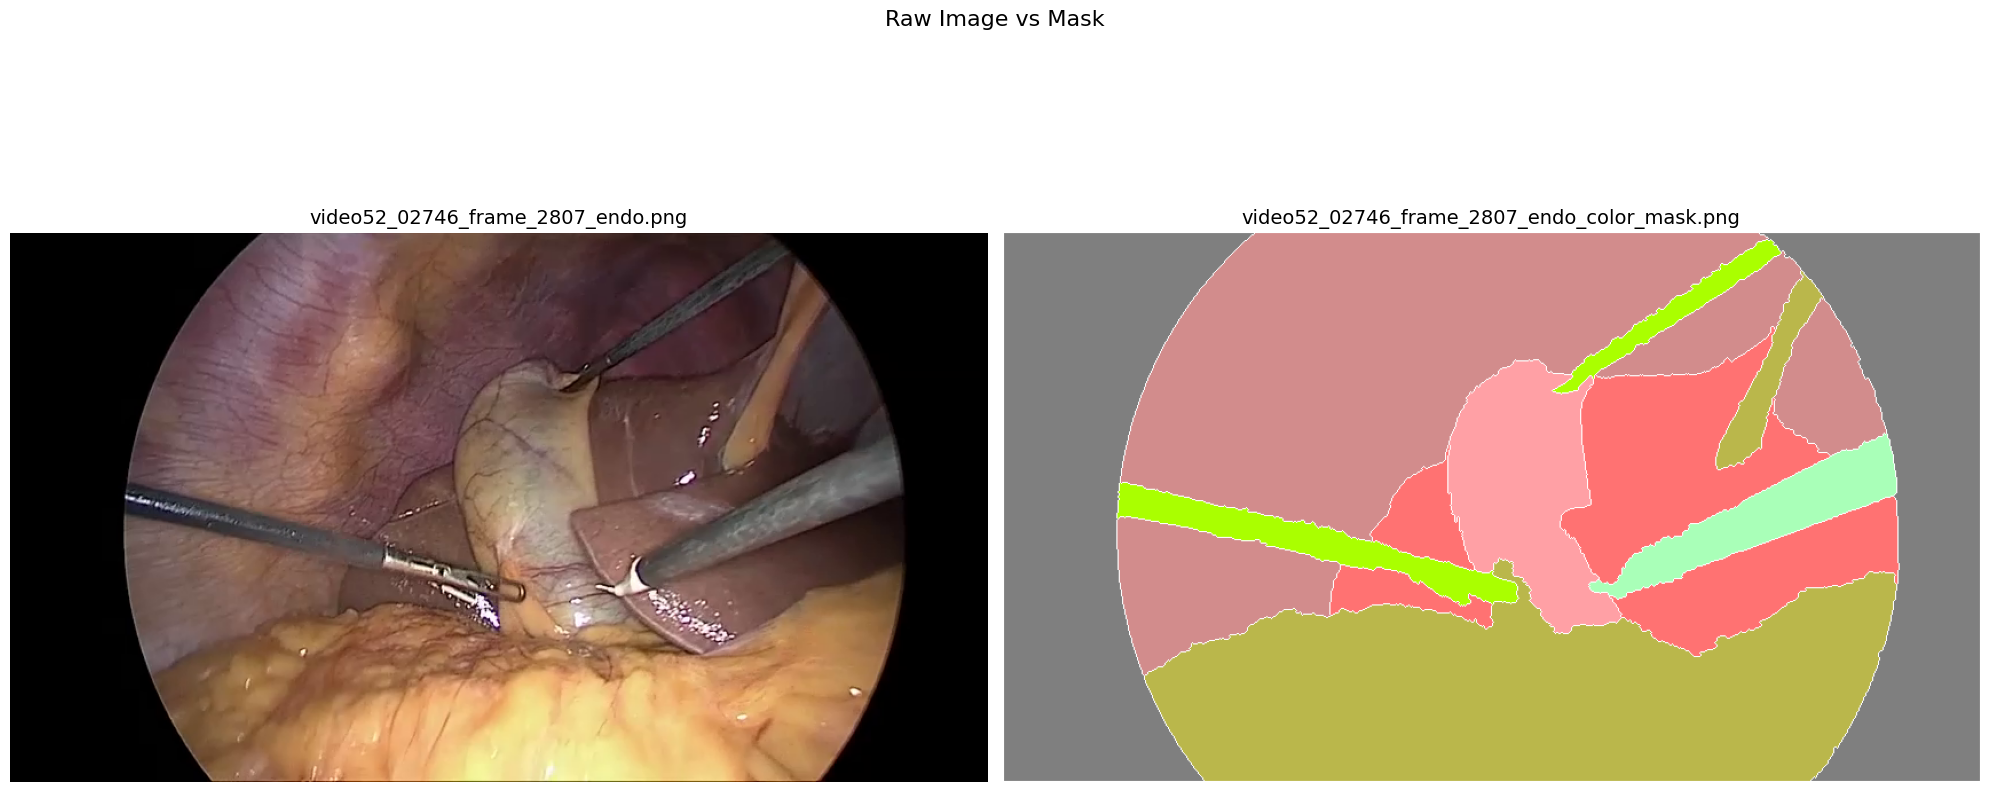

In [16]:
# Example usage:
plot_image_and_mask(rawimages_path, maskimages_path)


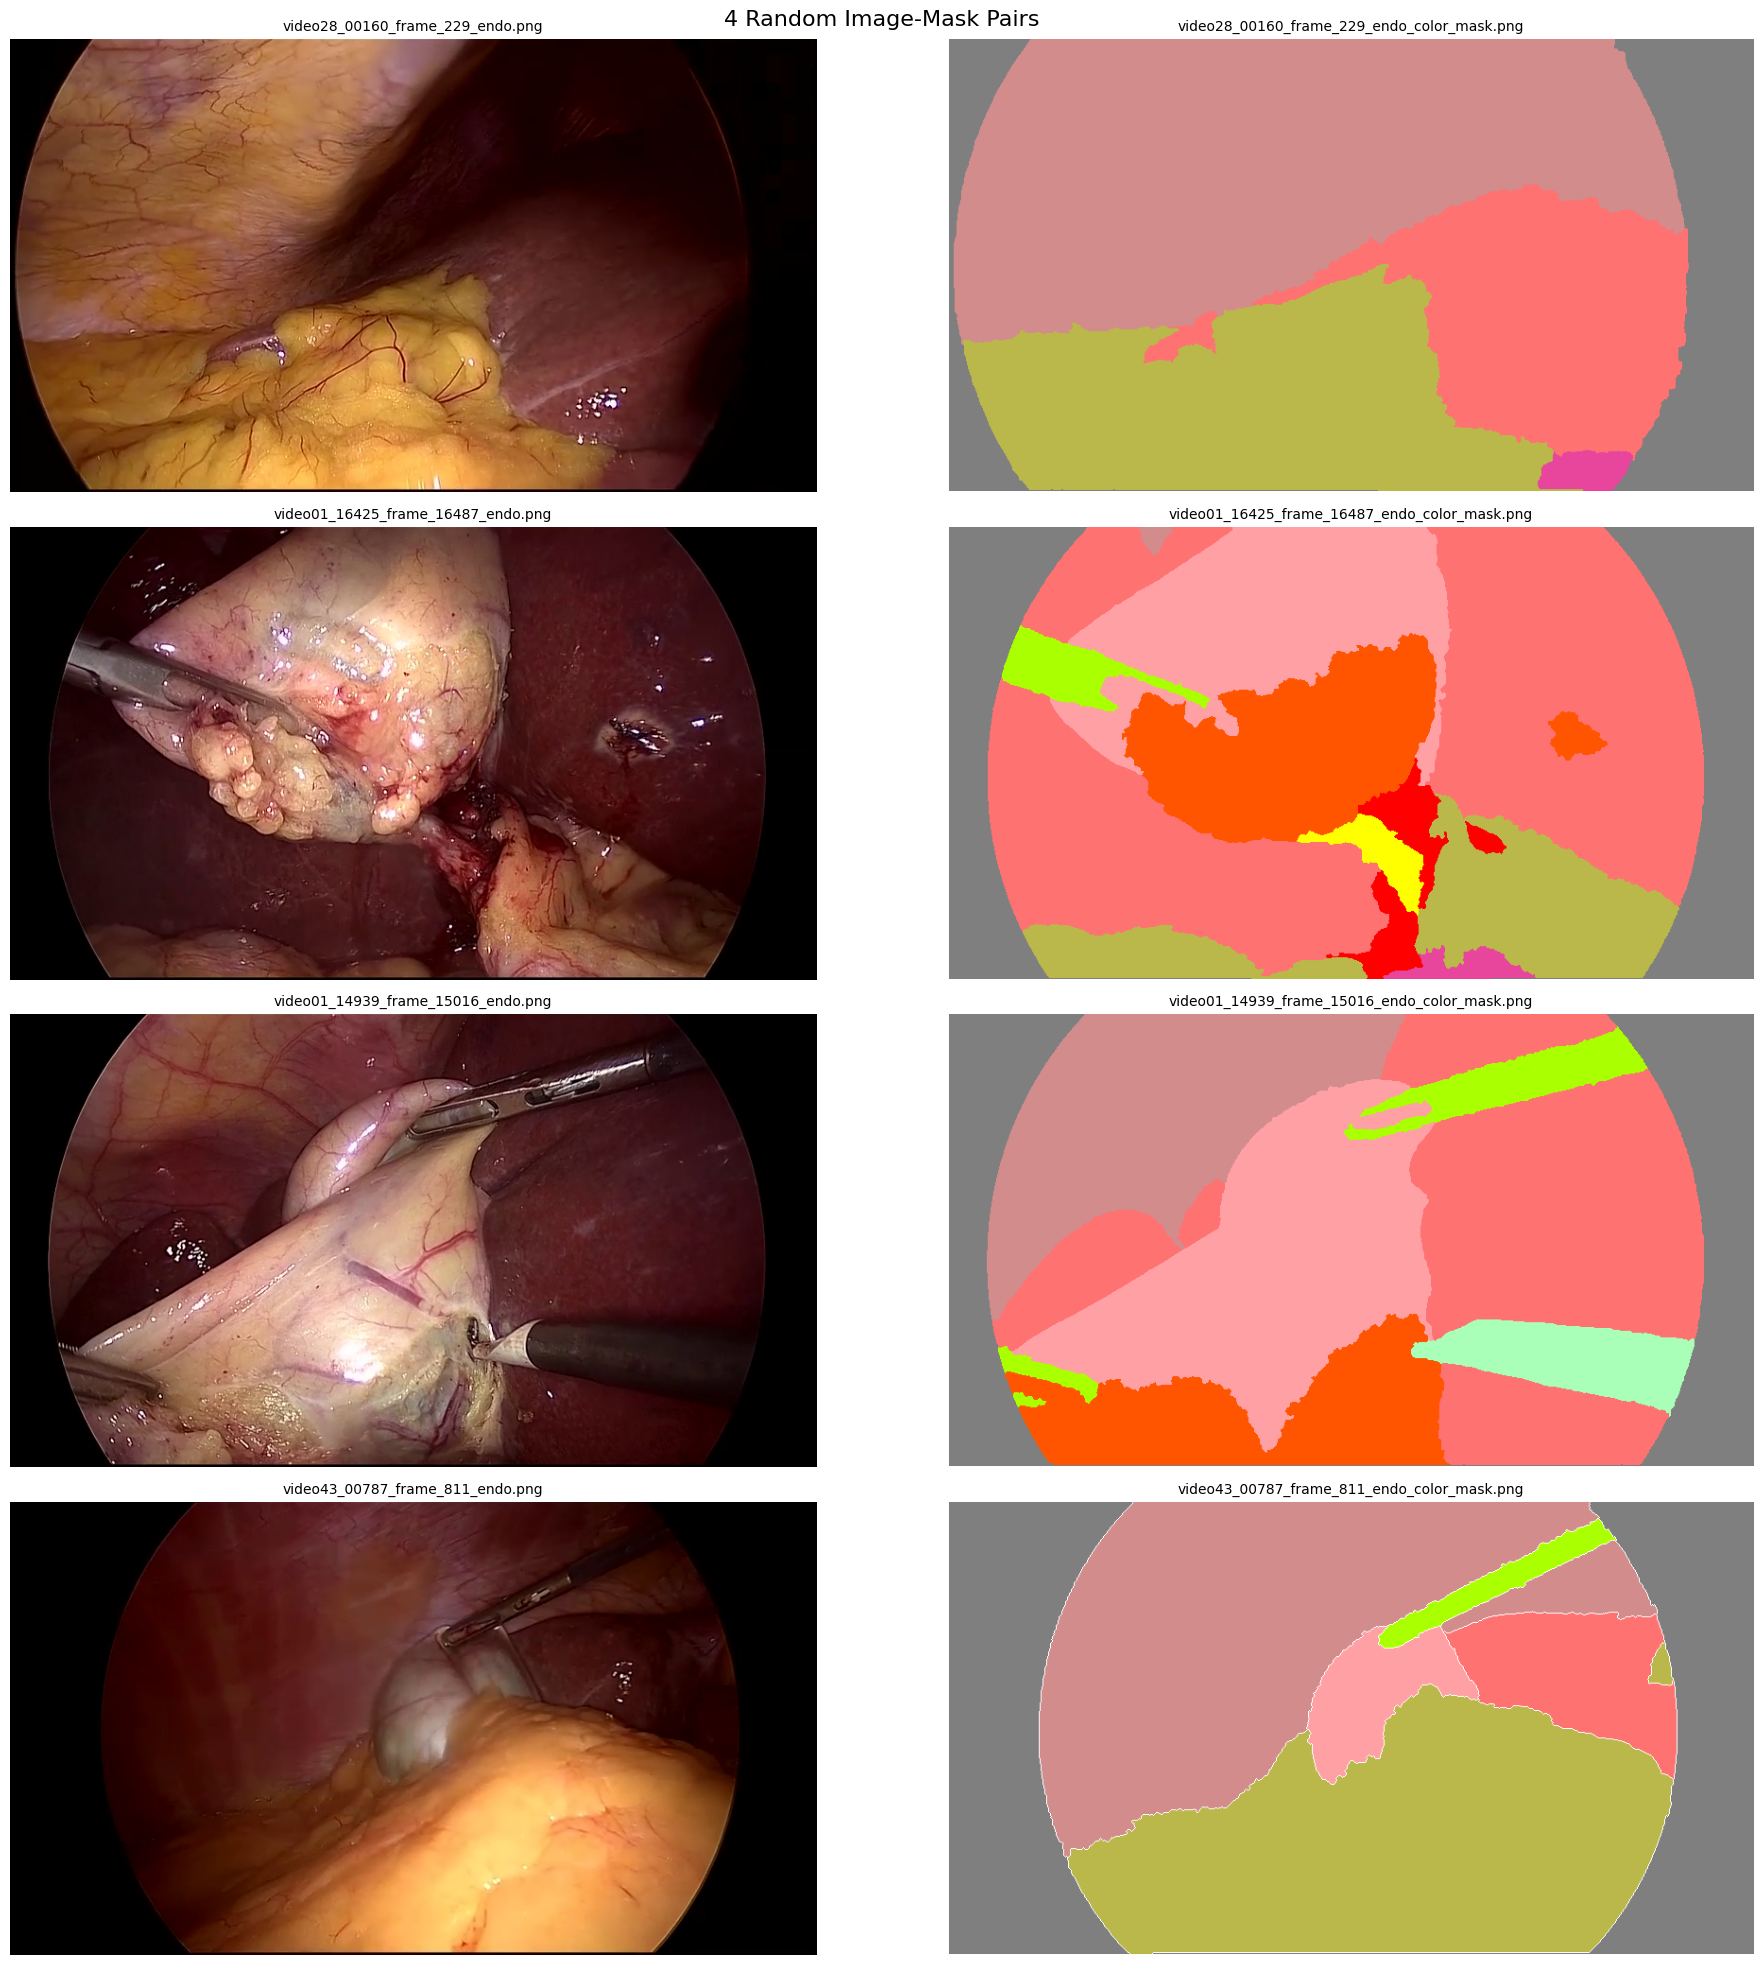

In [17]:
plot_multiple_pairs(rawimages_path, maskimages_path, num_pairs=4)

## Masks visualisation with contours

We will find unique colors in mask and draw segmentation contours for any color present in it. Since we don't have pure black color (RGB-0,0,0) for any of the classes in masks, we will use it to draw contours.

In [18]:
def draw_contour_for_one_color_on_mask(
    rawimages_path: str,
    rawimages_list: List[str],
    maskimages_path: str,
    maskimages_list: List[str]
) -> None:
    segmentation_classes = SegmentationClasses()
    
    # Choose a random image
    k = random.randint(0, len(rawimages_list) - 1)
    
    # Load images
    img_path = os.path.join(rawimages_path, rawimages_list[k])
    mask_path = os.path.join(maskimages_path, maskimages_list[k])
    
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)
    
    if img is None or mask is None:
        raise ValueError("Failed to load image or mask")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    
    # Get unique colors in mask
    unique_colors = np.unique(mask.reshape(-1, 3), axis=0)
    defined_colors = [color for color in unique_colors if tuple(color) in segmentation_classes.color_to_class]
    
    if not defined_colors:
        raise ValueError("No defined colors found in the mask")
    
    # Select a random color
    color = random.choice(defined_colors)
    
    # Get class information
    class_index = segmentation_classes.get_class_from_color(tuple(color))
    class_name = segmentation_classes.get_name_from_class(class_index)
    
    # Create mask for the selected color and find contours
    color_mask = cv2.inRange(mask, color, color)
    contours, _ = cv2.findContours(color_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw contours on a copy of the mask
    mask_with_contour = mask.copy()
    cv2.drawContours(mask_with_contour, contours, -1, (0, 0, 0), 4)
    
    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(30, 10))
    images = [img, mask, mask_with_contour]
    titles = [
        os.path.basename(img_path),
        'Mask',
        f'Mask with contour on {class_name}'
    ]
    
    for ax, image, title in zip(axes, images, titles):
        ax.imshow(image)
        ax.set_title(title, fontsize=20)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

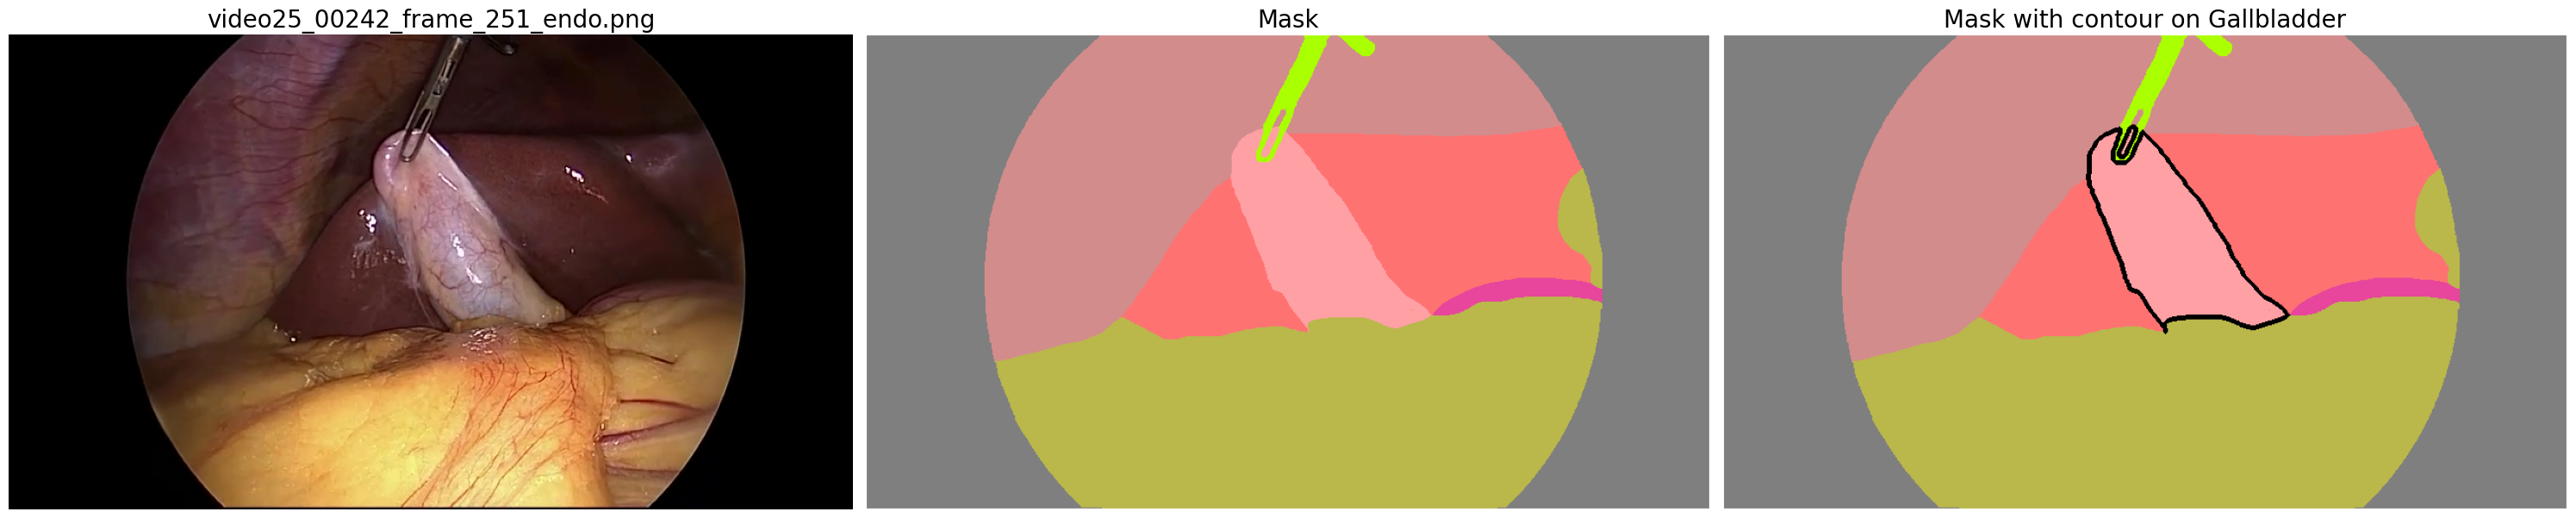

In [41]:
draw_contour_for_one_color_on_mask(rawimages_path, rawimages_list, maskimages_path, maskimages_list)

## Writing text file for masks

In [27]:
from tqdm import tqdm
def process_mask_images(maskimages_list: List[str], maskimages_path: str, labels_path: str, segmentation_classes: SegmentationClasses) -> int:
    total_labels = 0

    for img in tqdm(maskimages_list, desc="Processing mask images"):
        # Extract shortened mask name
        parts = img.split('_')
        endo_index = parts.index('endo')
        newname = '_'.join(parts[:endo_index+1])
        
        # Read the image
        image_path = os.path.join(maskimages_path, img)
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        
        # Get unique colors present in mask
        unique_colors = np.unique(image.reshape(-1, 3), axis=0)
        
        # Filter colors defined in segmentation_classes
        unique_colors_defined = [color for color in unique_colors if tuple(color) in segmentation_classes.color_to_class]
        
        H, W, _ = image.shape
        class_contour_mapping = {}

        for color in unique_colors_defined:
            class_code = segmentation_classes.get_class_from_color(tuple(color))
            mask = cv2.inRange(image, color, color)
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            class_contour_mapping[class_code] = contours
            
        # Write label text file    
        write_polygon_file(class_contour_mapping, H, W, labels_path, newname)
        total_labels += 1
    
    return total_labels

def write_polygon_file(class_contour_mapping: Dict[int, List], H: int, W: int, output_path: str, img_name: str):
    coordinates = {}
    min_contour_area = 20

    for class_code, contours in class_contour_mapping.items():
        polygons = []
        for cnt in contours:
            if cv2.contourArea(cnt) > min_contour_area:
                polygon = np.round(cnt.squeeze() / [W, H], 4).flatten().tolist()
                polygons.append(polygon)
        if polygons:
            coordinates[class_code] = polygons

    output_file = os.path.join(output_path, f"{img_name}.txt")
    with open(output_file, 'w') as f:
        for class_code, polygons in coordinates.items():
            for polygon in polygons:
                polygon_str = ' '.join(map(str, polygon))
                f.write(f"{class_code} {polygon_str}\n")

In [28]:
total_labels = process_mask_images(maskimages_list, maskimages_path, labels_path, segmentation_classes)
print(f"Total number of labels created: {total_labels}")

Processing mask images: 100%|██████████| 8080/8080 [36:40<00:00,  3.67it/s]

Total number of labels created: 8080


## Split the data into Training, Validation and Test data

In [29]:
from typing import List, Tuple
from sklearn.model_selection import train_test_split

def create_dataset(images_list: List[str], train_size: float = 0.8, val_size: float = 0.1, 
                   test_size: float = 0.1, random_state: int = 42) -> Tuple[List[str], List[str], List[str]]:
    """
    Create training, validation, and test datasets from a list of images.
    
    Args:
    images_list (List[str]): List of image file names.
    train_size (float): Proportion of the dataset to include in the train split.
    val_size (float): Proportion of the dataset to include in the validation split.
    test_size (float): Proportion of the dataset to include in the test split.
    random_state (int): Controls the shuffling applied to the data before applying the split.
    
    Returns:
    Tuple[List[str], List[str], List[str]]: Train, validation, and test image lists.
    """
    if not np.isclose(train_size + val_size + test_size, 1.0):
        raise ValueError("The sum of train_size, val_size, and test_size should be 1.0")
    
    # First, split off the test set
    train_val, test_images = train_test_split(images_list, test_size=test_size, random_state=random_state)
    
    # Then split the remaining data into train and validation sets
    relative_val_size = val_size / (train_size + val_size)
    train_images, val_images = train_test_split(train_val, test_size=relative_val_size, random_state=random_state)
    
    return train_images, val_images, test_images

In [30]:
train_images, val_images, test_images = create_dataset(rawimages_list)

In [31]:
# Print dataset sizes
print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(val_images)}")
print(f"Test set size: {len(test_images)}")

Training set size: 6464
Validation set size: 808
Test set size: 808


In [32]:

# Optional: Verify the proportions
total = len(rawimages_list)
print(f"Training set proportion: {len(train_images)/total:.2f}")
print(f"Validation set proportion: {len(val_images)/total:.2f}")
print(f"Test set proportion: {len(test_images)/total:.2f}")

Training set proportion: 0.80
Validation set proportion: 0.10
Test set proportion: 0.10


Now that the dataset is bifurcated, we will write a function to create names of label files corresponding to the names of image files

In [33]:
def create_label_filenames(image_files: List[str], label_extension: str = '.txt') -> List[str]:
    """
    Create label filenames from image filenames by changing the extension.
    
    Args:
    image_files (List[str]): List of image file names.
    label_extension (str): The extension to use for label files. Default is '.txt'.
    
    Returns:
    List[str]: List of label file names.
    """
    return [os.path.splitext(file)[0] + label_extension for file in image_files]

def create_dataset_labels(train_images: List[str], val_images: List[str], test_images: List[str], 
                          label_extension: str = '.txt') -> Tuple[List[str], List[str], List[str]]:
    """
    Create label filenames for train, validation, and test datasets.
    
    Args:
    train_images (List[str]): List of training image file names.
    val_images (List[str]): List of validation image file names.
    test_images (List[str]): List of test image file names.
    label_extension (str): The extension to use for label files. Default is '.txt'.
    
    Returns:
    Tuple[List[str], List[str], List[str]]: Train, validation, and test label file lists.
    """
    train_labels = create_label_filenames(train_images, label_extension)
    val_labels = create_label_filenames(val_images, label_extension)
    test_labels = create_label_filenames(test_images, label_extension)
    
    return train_labels, val_labels, test_labels

In [34]:
label_extension = '.txt'
train_labels, val_labels, test_labels = create_dataset_labels(train_images, val_images, test_images, label_extension)

In [35]:
# Print dataset sizes
print(f"Training set size: {len(train_labels)}")
print(f"Validation set size: {len(val_labels)}")
print(f"Test set size: {len(test_labels)}")

# Optional: Verify that the number of labels matches the number of images
assert len(train_labels) == len(train_images), "Mismatch in training set size"
assert len(val_labels) == len(val_images), "Mismatch in validation set size"
assert len(test_labels) == len(test_images), "Mismatch in test set size"

Training set size: 6464
Validation set size: 808
Test set size: 808


move images and labels to their respective directories

resize the images to a fixed size so that all images have exactly same size.

In [36]:
import os
import shutil
import cv2
from typing import List, Tuple
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

def resize_and_move_image(args: Tuple[str, str, str, int]) -> None:
    """
    Resize an image and move it to the destination path.
    
    Args:
    args (Tuple[str, str, str, int]): (file, source_path, destination_path, image_size)
    """
    file, source_path, destination_path, image_size = args
    filepath = os.path.join(source_path, file)
    finalimage_path = os.path.join(destination_path, file)
    img_resized = cv2.resize(cv2.imread(filepath), (image_size, image_size))
    cv2.imwrite(finalimage_path, img_resized)

def move_file(args: Tuple[str, str, str]) -> None:
    """
    Move a file from source to destination.
    
    Args:
    args (Tuple[str, str, str]): (file, source_path, destination_path)
    """
    file, source_path, destination_path = args
    filepath = os.path.join(source_path, file)
    shutil.move(filepath, destination_path)

def process_dataset(image_list: List[str], label_list: List[str], 
                    image_source_path: str, label_source_path: str,
                    image_dest_path: str, label_dest_path: str,
                    image_size: int = 640, max_workers: int = 4) -> None:
    """
    Process a dataset by resizing and moving images, and moving labels.
    
    Args:
    image_list (List[str]): List of image file names.
    label_list (List[str]): List of label file names.
    image_source_path (str): Source path for images.
    label_source_path (str): Source path for labels.
    image_dest_path (str): Destination path for images.
    label_dest_path (str): Destination path for labels.
    image_size (int): Size to resize images to. Default is 640.
    max_workers (int): Maximum number of worker threads. Default is 4.
    """
    os.makedirs(image_dest_path, exist_ok=True)
    os.makedirs(label_dest_path, exist_ok=True)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Process images
        image_args = [(file, image_source_path, image_dest_path, image_size) for file in image_list]
        list(tqdm(executor.map(resize_and_move_image, image_args), total=len(image_list), desc="Processing images"))

        # Process labels
        label_args = [(file, label_source_path, label_dest_path) for file in label_list]
        list(tqdm(executor.map(move_file, label_args), total=len(label_list), desc="Processing labels"))

In [37]:
image_size = 640
max_workers = 4  # Adjust based on your system's capabilities

# Process training set
process_dataset(train_images, train_labels, rawimages_path, labels_path, 
                imgtrainpath, labeltrainpath, image_size, max_workers)

# Process validation set
process_dataset(val_images, val_labels, rawimages_path, labels_path, 
                imgvalpath, labelvalpath, image_size, max_workers)

# Process test set
process_dataset(test_images, test_labels, rawimages_path, labels_path, 
                imgtestpath, labeltestpath, image_size, max_workers)

print("All datasets processed successfully.")

Processing labels: 100%|██████████| 808/808 [00:00<00:00, 19073.71it/s]

All datasets processed successfully.


Let's have the list of test masks handy as it will be required later for visualisation

In [38]:
from typing import List
import os

def create_mask_list(image_list: List[str], mask_suffix: str = '_color_mask.png') -> List[str]:
    """
    Create a list of mask filenames from a list of image filenames.
    
    Args:
    image_list (List[str]): List of image filenames.
    mask_suffix (str): Suffix to append to the base filename to create the mask filename.
                       Default is '_color_mask.png'.
    
    Returns:
    List[str]: List of corresponding mask filenames.
    """
    return [os.path.splitext(image)[0] + mask_suffix for image in image_list]


In [40]:
# Usage
mask_suffix = '_color_mask.png'
test_masks = create_mask_list(test_images, mask_suffix)

# Print some information
print(f"Number of test images: {len(test_images)}")
print(f"Number of test masks: {len(test_masks)}")

# Optional: Print a few examples to verify
print("\nExample mappings (image -> mask):")
for i in range(min(5, len(test_images))):
    print(f"{test_images[i]} -> {test_masks[i]}")

Number of test images: 808
Number of test masks: 808

Example mappings (image -> mask):
video52_00480_frame_547_endo.png -> video52_00480_frame_547_endo_color_mask.png
video12_19900_frame_19969_endo.png -> video12_19900_frame_19969_endo_color_mask.png
video52_02746_frame_2767_endo.png -> video52_02746_frame_2767_endo_color_mask.png
video12_19900_frame_19963_endo.png -> video12_19900_frame_19963_endo_color_mask.png
video52_02826_frame_2879_endo.png -> video52_02826_frame_2879_endo_color_mask.png


## Create Config File for YOLOv8-Seg Model Training

The config file is required to use YOLOv8 model. The names of classes present in dataset and the directories for the training, validation and test datasets are indicated in the config file.

In [42]:
# defining newline variable for config file
newline='\n'

Define the config file

In [43]:
# defining lines of config text file

ln_1='# Train/val/test sets'+newline # starting with a comment line

# train, val and test path declaration
ln_2='train: ' +"'"+imgtrainpath+"'"+newline
ln_3='val: ' +"'" + imgvalpath+"'"+newline
ln_4='test: ' +"'" + imgtestpath+"'"+newline
ln_5=newline

# names of the classes declaration
ln_6='# Classes'+newline
ln_7='names:'+newline
ln_8='  0: Black Background'+newline
ln_9='  1: Abdominal Wall'+newline
ln_10='  2: Liver'+newline
ln_11='  3: Gastrointestinal Tract'+newline
ln_12='  4: Fat'+newline
ln_13='  5: Grasper'+newline
ln_14='  6: Connective Tissue'+newline
ln_15='  7: Blood'+newline
ln_16='  8: Cystic Duct'+newline
ln_17='  9: L-hook Electrocautery'+newline
ln_18='  10: Gallbladder'+newline
ln_19='  11: Hepatic Vein'+newline
ln_20='  12: Liver Ligament'

#listing all config lines
config_lines=[ln_1, ln_2, ln_3, ln_4, ln_5, ln_6, ln_7, ln_8, ln_9, ln_10, ln_11, ln_12,
             ln_13, ln_14, ln_15, ln_16, ln_17, ln_18, ln_19, ln_20]

In [44]:
# Creating path for config file
config_path=os.path.join(op_path, 'config.yaml')
config_path

'data/config.yaml'

In [45]:
# Writing config file
with open(config_path, 'w') as f:
    f.writelines(config_lines)

In [46]:
# read the config file
with open(config_path, 'r') as f:
    config_file = f.read()

print(config_file)

# Train/val/test sets
train: 'data/images/train'
val: 'data/images/validation'
test: 'data/images/test'

# Classes
names:
  0: Black Background
  1: Abdominal Wall
  2: Liver
  3: Gastrointestinal Tract
  4: Fat
  5: Grasper
  6: Connective Tissue
  7: Blood
  8: Cystic Duct
  9: L-hook Electrocautery
  10: Gallbladder
  11: Hepatic Vein
  12: Liver Ligament


##  Model Training

In [48]:
# Using YOLO's pretrained model architecture and weights for training
model=YOLO('yolov8m-seg.yaml').load('weights/yolov8m-seg.pt')

Transferred 537/537 items from pretrained weights


### Model Training Arguments

In [77]:
args = dict(
    data="/Users/shaunliew/Documents/endoinsight-ai/config.yaml",  # Using the config_path you already have
    batch=8,
    device="mps",
    epochs=30,  # As per your original code
    workers=8,
    optimizer='AdamW',
    save_period=5,
    name='endo_segmentation',
    save=True,
    plots=True,
    patience=5,
    verbose=True,
    iou=0.4,
    conf=0.01,
    degrees=60, # Augmentation arguments
    shear=30,
    perspective=0.0005
)

In [78]:
#Initiating Model Training
results = model.train(**args)

New https://pypi.org/project/ultralytics/8.2.83 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.82 🚀 Python-3.10.4 torch-2.4.0 MPS (Apple M1)
engine/trainer: task=segment, mode=train, model=yolov8m-seg.yaml, data=/Users/shaunliew/Documents/endoinsight-ai/config.yaml, epochs=30, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=5, cache=False, device=mps, workers=8, project=None, name=endo_segmentation12, exist_ok=False, pretrained=weights/yolov8m-seg.pt, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=0.01, iou=0.4, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

Freezing layer 'model.22.dfl.conv.weight'


/Users/shaunliew/Documents/endoinsight-ai/venv/lib/python3.10/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
train: Scanning /Users/shaunliew/Documents/endoinsight-ai/data/labels/train... 6464 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6464/6464 [00:20<00:00, 310.32it/s]


train: New cache created: /Users/shaunliew/Documents/endoinsight-ai/data/labels/train.cache


val: Scanning /Users/shaunliew/Documents/endoinsight-ai/data/labels/validation... 808 images, 0 backgrounds, 0 corrupt: 100%|██████████| 808/808 [00:03<00:00, 263.08it/s]


val: New cache created: /Users/shaunliew/Documents/endoinsight-ai/data/labels/validation.cache
Plotting labels to /Users/shaunliew/Documents/unattended_baggage_dataset/runs/segment/endo_segmentation12/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/shaunliew/Documents/unattended_baggage_dataset/runs/segment/endo_segmentation12
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G       1.35       3.94      1.772      1.709        138        640:  63%|██████▎   | 508/808 [3:48:58<2:15:13, 27.04s/it]


KeyboardInterrupt: 